# Data fitting and parameter estimation with PyGOM

This example of parameter fitting with an SIR model is taken from the PyGOM documentation.

In [1]:
from pygom import SquareLoss, common_models
import numpy
import scipy.integrate
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [2]:
# Generate some data for fitting

# Standard SIR model with 2 parameters

# Define the parameters
paramEval = [('beta',0.5), ('gamma',1.0/3.0)]

# initialize the model
ode = common_models.SIR(paramEval)

# Initial conditions (normalized to 1) and time scale
x0 = [1-1.27e-6, 1.27e-6, 0]
t = numpy.linspace(0, 70, 36)

# Find the solution.
solution = scipy.integrate.odeint(ode.ode, x0, t)
y = solution[:,1:3].copy()



Data over 70 days, with observations from every other day for infected and removed populations.

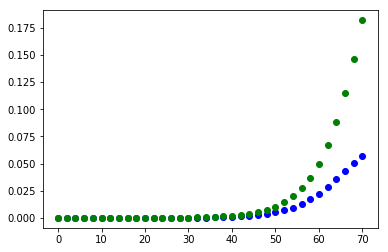

In [3]:
plt.plot(t,y[:,0], 'bo') # infected observations
plt.plot(t,y[:,1], 'go') # removed observations (recoverd/died)

plt.show()

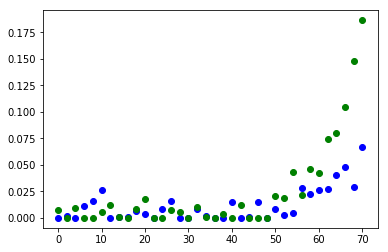

In [4]:
# Add noise
numpy.random.seed(seed=6)
noise = numpy.random.normal(0,1.e-2,[len(t),2])
ynoise = y + noise
ynoise[ynoise<0] = 0
plt.plot(t,ynoise[:,0], 'bo') # infected observations
plt.plot(t,ynoise[:,1], 'go') # removed observations (recoverd/died)
plt.show()

We provide a guess for $\beta$ and $\gamma$. 

This example assumes we have information about the infected and removed population, up to 50 days of the epidemic.


In [5]:
# Initial guess of parameters, and bounding constraints
theta = [0.2, 0.2]
boxBounds = [(0.0,5.0),(0.0,5.0)]

objSIR = SquareLoss(theta, ode, x0, t[0], t[1::], ynoise[1::,:], ['I','R'])

In [ ]:
numpy.shape(y[1::,:])

In [14]:
objSIR.residual()

array([[  2.17821008e-03,  -1.00679470e-06],
       [ -2.47455621e-06,   9.13252444e-03],
       [  1.12706443e-02,  -4.37384808e-06],
       [  1.63929211e-02,  -7.11209066e-06],
       [  2.63128219e-02,   6.01824116e-03],
       [ -9.39395899e-06,   1.23774086e-02],
       [  1.11132106e-03,   1.29156109e-03],
       [  7.61330447e-04,  -3.41105637e-05],
       [  6.34233147e-03,   8.10664427e-03],
       [  3.54819616e-03,   1.81260357e-02],
       [ -4.97637679e-05,  -9.71327842e-05],
       [  8.24674509e-03,  -1.36578906e-04],
       [  1.56451751e-02,   7.12736462e-03],
       [ -1.35241634e-04,   5.34240959e-03],
       [ -1.88688164e-04,  -3.75633163e-04],
       [  8.57311457e-03,   9.43160063e-03],
       [  1.14524286e-03,  -2.18839553e-04],
       [ -5.11689262e-04,  -1.02450525e-03],
       [ -7.12945453e-04,   2.33801084e-03],
       [  1.38520671e-02,  -1.99422683e-03],
       [ -1.38068974e-03,   9.55687504e-03],
       [ -1.26472040e-03,  -3.87155735e-03],
       [  

In [11]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='SLSQP')
print(res)

     fun: 0.004952043094666394
     jac: array([ 0.00327445, -0.0030997 ])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 18
    njev: 17
  status: 0
 success: True
       x: array([ 0.50069402,  0.33393774])


Our estimated parameters, with the provided data, are:

In [7]:
res.x

array([ 0.50069402,  0.33393774])

We can now simulate the epidemic with the fitted parameters.

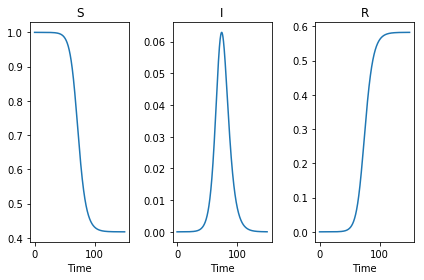

Peak infection (days) 74.3243243243
R0 (beta/gamma) =  1.49936341506


In [8]:
# model with fitted parameters 
ode_fit = common_models.SIR({'beta':res.x[0], 'gamma':res.x[1]})
x0_fit = [1-1.27e-6, 1.27e-6, 0]
t_fit = numpy.linspace(0, 150, 1000)
ode_fit.initial_values = (x0_fit, t_fit[0])
sol_fit = ode_fit.integrate(t_fit[1::])
ode_fit.plot()

peak_i = numpy.argmax(sol_fit[:,1])
print('Peak infection (days)', t_fit[peak_i])
print('R0 (beta/gamma) = ', res.x[0]/res.x[1])

## Important points for consideration when parameter fitting

- Cleaned data
- Missing data
- Restrictions due to modelling assumptions

It is important to refer back to epidemiological information about the diseases.

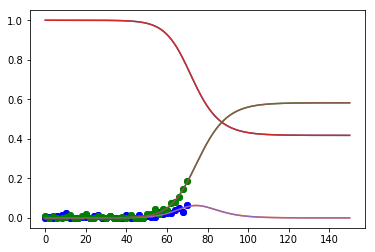

In [10]:
plt.plot(t,ynoise[:,0], 'bo') # infected observations
plt.plot(t,ynoise[:,1], 'go') # removed observations (recoverd/died)
plt.plot(t_fit, sol_fit)
plt.show(())